# XID+ Example Output Analysis

(This is based on a Jupyter notebook, available in the [XID+ package](https://github.com/H-E-L-P/XID_plus/tree/master/docs/notebooks/examples/) and can be interactively run and edited)

This notebook provides some example code for basic analysis of the XID+ outputs, including:

1. Loading up output
2. Creating Posterior replicated maps and animations
3. Creating marginalised posterior plots
4. Creating Bayesian p-value maps

Import required modules

In [1]:
import pylab as plt
%matplotlib inline


import numpy as np
import xidplus
from xidplus import moc_routines
output_folder='./'

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Load up posterior output from XID+

In [2]:
priors,posterior=xidplus.load('test.pkl')

In order to compare how good our fit is, its often useful to look at original map. There is a routine within XID+ that makes the original fits map from the data stored within the prior class. Lets use that to make the SPIRE maps for the region we have fit.

Now lets use the [Seaborn](https://stanford.edu/~mwaskom/software/seaborn/index.html) plotting package and [APLpy](http://aplpy.readthedocs.io/en/stable/) package to view those maps, plotting the sources we have fit on top of those maps.

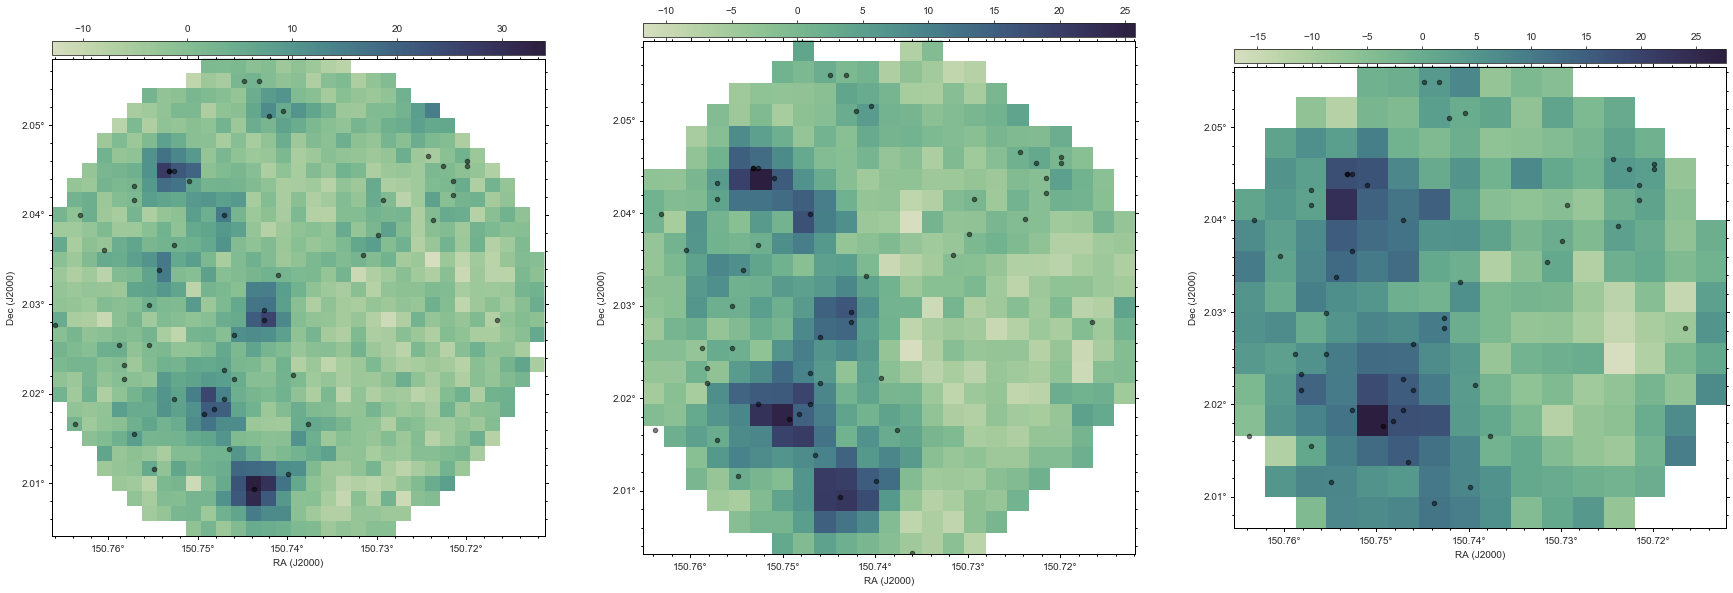

In [3]:
figs,fig=xidplus.plot_map(priors)

### Posterior replicated data

We can use each sample we have from the posterior, and use it to make a replicated map, including simulating the instrumental noise, and the estimated confusion noise. You can think of these maps as all the possible maps that are allowed by the data. 

> NOTE: You will require the `FFmpeg` library installed to run the movie

In [4]:
xidplus.replicated_map_movie(priors,posterior,50)

### Joint Posterior Analysis of sources

In [5]:
#Select source you want to plot joint distribution
s1=2
s2=18

Sources 2 and 18 are close together, lets look at their joint posterior probabiity distribution. The code below is an example of how you can plot the joint posterior probability density function for the $250 \mathrm{\mu m}$ flux, and an inset of the real map.

INFO: Auto-setting vmin to -1.522e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.332e+01 [aplpy.core]


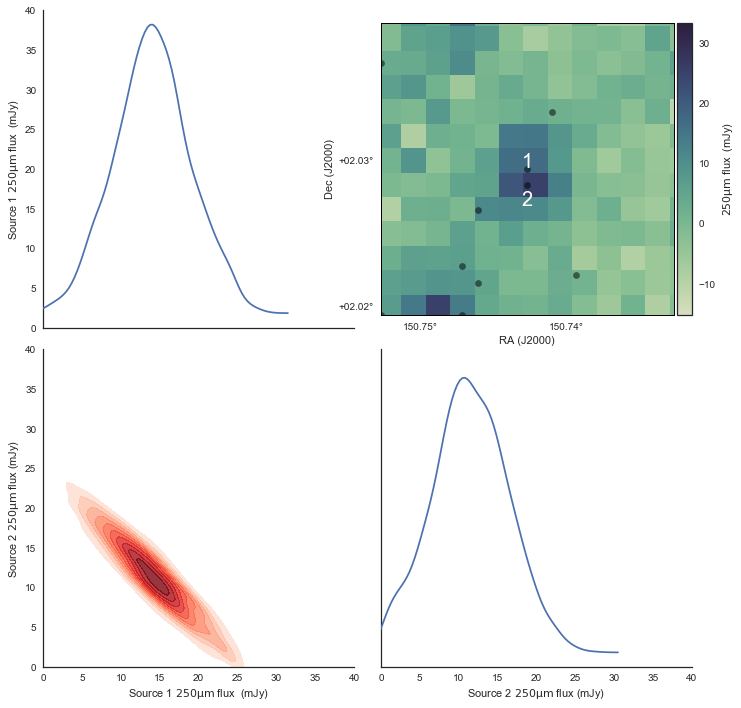

In [6]:
import aplpy
import seaborn as sns
sns.set(color_codes=True)
import pandas as pd
sns.set_style("white")
import xidplus.posterior_maps as postmaps



labels=[r'Source 1 $250\mathrm{\mu m}$ flux  (mJy)',r'Source 2 $250\mathrm{\mu m}$ flux (mJy)']
df = pd.DataFrame(posterior.samples['src_f'][:,0,[s1,s2]],columns=labels)
g = sns.PairGrid(df,size=5)
g.map_diag(sns.kdeplot,c='Red')
g.map_lower(sns.kdeplot, cmap="Reds",alpha=0.8,n_levels=10,normed=True, shade=True,shade_lowest=False)
g.set(ylim=(0,40))
g.set(xlim=(0,40))

g.axes[0,1].spines['bottom'].set_color('white')
g.axes[0,1].spines['left'].set_color('white')
cmap=sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True)

real_250 = aplpy.FITSFigure(postmaps.make_fits_image(priors[0],priors[0].sim)[1],figure=g.fig,subplot=(2,2,2))
real_250.show_colorscale(cmap=cmap)

real_250.show_markers(priors[0].sra, priors[0].sdec, edgecolor='black', facecolor='black',
                marker='o', s=40, alpha=0.5)
real_250.recenter(priors[0].sra[s1], priors[0].sdec[s1], radius=0.01)

real_250.add_label(priors[0].sra[s1], priors[0].sdec[s1]+0.0005, 1, relative=False,size=20,color='white')
real_250.add_label(priors[0].sra[s2], priors[0].sdec[s2]-0.0010, 2, relative=False,size=20,color='white')
real_250.tick_labels.set_xformat('dd.dd')
real_250.tick_labels.set_yformat('dd.dd')


real_250.add_colorbar(axis_label_text=r'$250\mathrm{\mu m}$ flux  (mJy)')  


### Posterior Predictive checking and Bayesian P-value maps

When examining goodness of fits, the typical method is to look at the residuals. i.e. $\frac{data - model}{\sigma}$. Because we have distribution of $y^{rep}$, we can do this in a more probabilisitic way using posterior predictive checks. For more information on posterior predictive checks, [Gelman et al. 1996](http://www.stat.columbia.edu/~gelman/research/published/A6n41.pdf) is a good starting point.



For our case, the best way to carry out posterior predictive checks is to think about one pixel. We can look at where the real flux value for our pixel is in relation to the distribution from $y^{rep}$. 



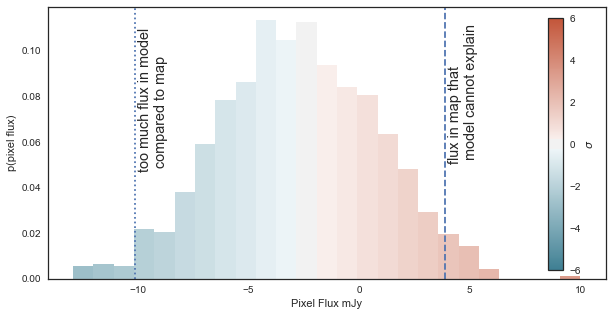

In [37]:
from xidplus import posterior_maps as postmaps

rep_maps=postmaps.replicated_maps(priors,posterior)

import matplotlib as mpl
sns.set_style("white")

fig=plt.figure(figsize=(10,5))


# This is  the colormap I'd like to use.
cm = sns.diverging_palette(220, 20, as_cmap=True)

# Get the histogramp
Y,X = np.histogram(rep_maps[0][20,:], 25, normed=1)
#C = [cm(((x-X.min())/x_span)) for x in X]
C = [cm(((((x-np.mean(rep_maps[0][20,:]))/np.std(rep_maps[0][20,:]))+6)/12.0)) for x in X]


plt.bar(X[:-1],Y,color=C,width=X[1]-X[0])
plt.xlabel('Pixel Flux mJy')
plt.ylabel('p(pixel flux)')
plt.axvline(3.9, linestyle='--')
plt.axvline(-10.1,linestyle=':')
plt.annotate('flux in map that \n model cannot explain',xy=(4, 0.01),  xycoords='data',
            xytext=(4, 0.1), textcoords='data',rotation='vertical',size='large')
plt.annotate('too much flux in model \n compared to map',xy=(-10, 0.01),  xycoords='data',
            xytext=(-10, 0.1), textcoords='data',rotation='vertical',size='large')

#ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
ax1 = fig.add_axes([0.82, 0.15, 0.02, 0.7])

norm = mpl.colors.Normalize(vmin=-6, vmax=6)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cm,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('$\sigma$')

We can calculate fraction of $y^{rep}$ samples above and below real map value. This is often referred to as the Bayesian p-value and is telling us the probability of drawing the real pixel value, from our model which has been inferred on the data. This is tells us if the model is inconsistent with the data, given the uncertianties in parameters and data.

* $\sim 0.5$ means our model is consistent with the data 
* 0.99 or 0.01 means model is missing something.

We can convert this to a typical '$\sigma$' level and create map versions of these Bayesian p-values:

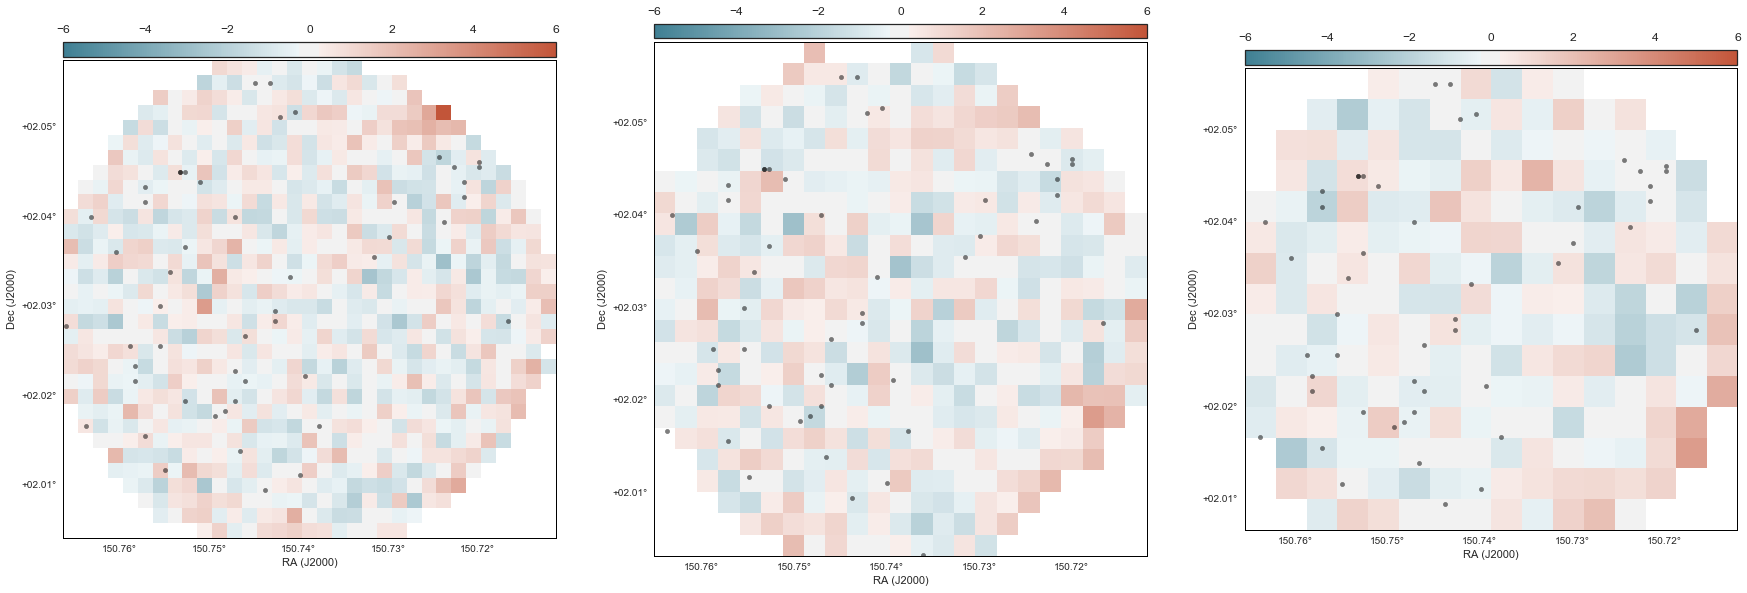

In [13]:
figs, fig=xidplus.plot_Bayes_pval_map(priors, posterior)

Red indicates the flux value in the real map is higher than our model thinks is possible. This could be indicating there is a source there that is not in our model.
Blue indicates the flux in the real map is lower than in our model. This is either indicating a very low density region or that too much flux has been assigned to one of the sources.

### Creating Catalogues

We can also create catalogues from the posterior probability density function

In [14]:
import xidplus.catalogue as cat

In [16]:
SPIRE_cat=cat.create_SPIRE_cat(posterior,priors[0],priors[1],priors[2])
SPIRE_cat.writeto('test.fits',overwrite=True)

### Check table
Lets read in table with Astropy table

In [20]:
from astropy.table import Table

In [21]:
catalogue=Table.read('test.fits')

In [22]:
catalogue

<Table length=51>
HELP_ID       RA           Dec      ... Pval_res_250 Pval_res_350 Pval_res_500
           degrees       degrees    ...                                       
 str27     float64       float64    ...   float32      float32      float32   
------- ------------- ------------- ... ------------ ------------ ------------
   1891  150.74711462 2.01937229149 ...          0.0        0.001          0.0
   1896  150.74655644 2.01381734435 ...          0.0        0.003          0.0
   2640 150.742672167 2.02937330604 ...          0.0        0.008          0.0
   5128 150.752680282 2.03659114242 ...          0.0        0.017        0.001
   5129 150.741006288  2.0332625701 ...          0.0        0.018          0.0
   5130 150.747123319 2.03992641714 ...          0.0        0.003        0.001
   5159 150.754346603 2.03381290524 ...        0.002        0.004        0.001
   6067 150.755456605 2.02992385524 ...        0.002        0.023        0.002
   6728 150.731557942 2.03548824889 ...        0.001          0.0        0.002
    ...           ...           ... ...          ...          ...          ...
  54557 150.747116031 2.02270538967 ...          0.0        0.003          0.0
  56696 150.721556173 2.04382481093 ...        0.014        0.002        0.008
  56700 150.729337091 2.04159980217 ...        0.001          0.0        0.004
  57200 150.740458126 2.05159489041 ...          0.0        0.001        0.005
  58792 150.739334129 2.02215285778 ...          0.0        0.002          0.0
  62679 150.751015847 2.04381351831 ...          0.0          0.0        0.004
  62696 150.716547293 2.02827210175 ...        0.001        0.068        0.226
  64788 150.757117895 2.01547979941 ...          0.0        0.003        0.004
  64789 150.722668543 2.04549095568 ...        0.319        0.001        0.002
  64790 150.746006008 2.02659443544 ...          0.0        0.004          0.0